In [79]:
# Read the lines (together case)

file = open('./crossFiles/yy_cross_v4.txt', 'r')  # differential cross-section distribution generated by STRINGS
comparison_csv = './digitized_data/oct 26/photon_both.csv'                   # digitized data from paper
gg_or_both = 'both'
lin_or_log = 'lin'
lines = file.readlines()
file.close()
print(len(lines))

305


In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import math as math
import itertools
import os
import scipy
from scipy.optimize import curve_fit
from scipy.special import wofz

In [74]:
# Make arrays

spaces = []       # where the spaces are in each line.
first, second, third, fourth, fifth, sixth, seventh = [], [], [], [], [], [], []

gg_cross, gq_cross = [], []    # total cross-sections
q1, q2, q3, q4, q5 = [], [], [], [], []      # cross section for each quark

for line in enumerate(lines):
    for i in range(len(line[1])):
        if line[1][i] == ' ':
            spaces.append(i)

i = 0                # counter
while i < (len(spaces)):

    first.append(spaces[i])
    second.append(spaces[i+1])
    third.append(spaces[i+2])
    fourth.append(spaces[i+3])
    fifth.append(spaces[i+4])
    sixth.append(spaces[i+5])
    seventh.append([i+6])
    i = i + 7

i = 0                # counter
for line in enumerate(lines):

    gg_cross.append(line[1][0 : first[i]])
    gg_cross[i] = float(gg_cross[i])
    q1.append(line[1][first[i]+1 : second[i]])
    q1[i] = float(q1[i])
    q2.append(line[1][second[i]+1 : third[i]])
    q2[i] = float(q2[i])
    q3.append(line[1][third[i]+1 : fourth[i]])
    q3[i] = float(q3[i])
    q4.append(line[1][fourth[i]+1 : fifth[i]])
    q4[i] = float(q4[i])
    q5.append(line[1][fifth[i]+1 : sixth[i]])
    q5[i] = float(q5[i])
    gq_cross.append(q1[i] + q2[i] + q3[i] + q4[i] + q5[i])
    i = i + 1

total = []
for i in range(len(gg_cross)):
    total.append(gg_cross[i] + gq_cross[i])

In [75]:
M = 50                                 # Make the invariant mass array; lower limit on invariant mass interval
invariant_Mass = []

while M < 3100:
    invariant_Mass.append(M)
    M = M + 10

for i in range(len(invariant_Mass)):   # For STRINGS, which is in uniits of fb/GeV. Need to convert to pb/GeV by dividing by 1000
    invariant_Mass[i] = invariant_Mass[i]
    gg_cross[i] = gg_cross[i]/1000
    gq_cross[i] = gq_cross[i]/1000
    total[i] = total[i]/1000

In [76]:
a = total[0]       # Find the lower mass cut, make seperate arrays at the peak
Ms = 2000

for i in range(len(total)):
    if total[i] < a:
        a = total[i]
        Lowcut = invariant_Mass[i]
        lowcut_index = i
    if invariant_Mass[i] == Ms:
        break

invariant_Mass_peak = np.array( invariant_Mass[155:235] )
gg_cross_peak = np.array( gg_cross[155:235] )
total_peak = np.array( total[155:235])

print('The lower mass cut is', Lowcut, 'TeV')

The lower mass cut is 1240 TeV


In [77]:
df = np.genfromtxt(comparison_csv, delimiter=',')  # Read-in comparison plot, and generate comparison points with the same x-coords
df_x, df_y = [], []

for i in range(len(df)):
    df_x.append(df[i][0])
    df_y.append( 25 * df[i][1])

comparison_points = np.interp(invariant_Mass, df_x, df_y)
comparison_points_peak = comparison_points[155:235]

paperMax, ourMax = 0, 0                             # Find maximums for each set, and half maxes

for i in range(len(comparison_points_peak)):

    if gg_or_both == 'both':
        if total_peak[i] > ourMax:
            ourMax = total_peak[i]
    if gg_or_both == 'gg':
        if gg_cross_peak[i] > ourMax:
            ourMax = gg_cross_peak[i]

    if comparison_points_peak[i] > paperMax:
        paperMax = comparison_points_peak[i]

df_y_max = 0
for element in df_y[110:235]:
    if element > df_y_max:
        df_y_max = element

scaleFactor = paperMax/ourMax                        # scale data to get peaks to line up (if you want to)
print('Scale factor is', scaleFactor)

ourHalfmax = ourMax/2
paperHalfmax = paperMax/2

print('Max for paper is:', df_y_max, '(Using raw data)')
print('Max for paper is:', paperMax, '; Max for us is:', ourMax, '(Using comparison points)')
print('Half-max for paper is:', paperHalfmax, '; Half-max for us is:', ourHalfmax)

Scale factor is 38.216515454168906
Max for paper is: 0.07164674586727915 (Using raw data)
Max for paper is: 0.0715985488874003 ; Max for us is: 0.001873497571312192 (Using comparison points)
Half-max for paper is: 0.03579927444370015 ; Half-max for us is: 0.000936748785656096


M: 1990.150480737425 +- 0.8811689923331691
Gamma: -152.97395187554196 +- 2.6890921242452586
K: 1053038372.4356893 +- 29568053.340198632
M: 1998.3038958467132 +- 0.6700503253011106
Gamma: -44.37628549544006 +- 1.8974121610571535
K: 3783122288.4613004 +- 255861230.71339166


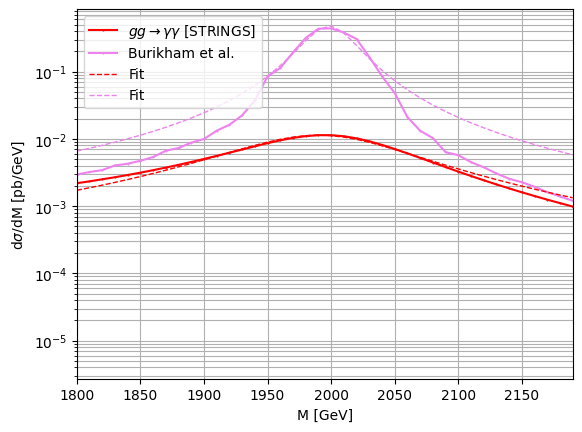

In [72]:
# 3 param BW fitting

fig, ax = plt.subplots()
plt.xlim(min(invariant_Mass_peak), max(invariant_Mass_peak))

def BW(x, M, gamma, K):
    P = K / ( (x**2-M**2)**2 + (M**2 * gamma**2) )
    return P

initial_guess = [2000, 100, 1e7]   # M, gamma, K guesses

if gg_or_both == 'both':
    params, covariance = curve_fit(BW, invariant_Mass_peak, total_peak, initial_guess)
if gg_or_both == 'gg':
    params, covariance = curve_fit(BW, invariant_Mass_peak, gg_cross_peak, initial_guess)

our_fitted_M, our_fitted_gamma, our_fitted_K = params
our_y_fit = [BW(x, our_fitted_M, our_fitted_gamma, our_fitted_K) for x in invariant_Mass_peak]  # get fitted curve

print('STRINGS:')
print('M:', our_fitted_M, '+-', np.sqrt(covariance[0][0]))
print('Gamma:', our_fitted_gamma, '+-', np.sqrt(covariance[1][1]))
print('K:', our_fitted_K, '+-', np.sqrt(covariance[2][2]))
print('-----------------------')

initial_guess = [2000, 100, 1e7]   # M, gamma, K guesses
params, covariance = curve_fit(BW, invariant_Mass_peak, comparison_points_peak, initial_guess)
their_fitted_M, their_fitted_gamma, their_fitted_K = params
their_y_fit = [BW(x, their_fitted_M, their_fitted_gamma, their_fitted_K) for x in invariant_Mass_peak]  # get fitted curve

print('PAPER:')
print('M:', their_fitted_M, '+-', np.sqrt(covariance[0][0]))
print('Gamma:', their_fitted_gamma, '+-', np.sqrt(covariance[1][1]))
print('K:', their_fitted_K, '+-', np.sqrt(covariance[2][2]))

if gg_or_both == 'both':
    plt.plot(invariant_Mass, total, label=r'$gg + q\bar{q} \rightarrow \gamma \gamma$ [STRINGS]', marker='o', color='red', alpha=1, markersize=0.5)
    plt.plot(invariant_Mass, comparison_points, label=r'Burikham et al.', marker='o', color='violet', alpha=1, markersize=0.5)
if gg_or_both == 'gg':
    plt.plot(invariant_Mass, gg_cross, label=r'$gg \rightarrow \gamma \gamma$ [STRINGS]', marker='o', color='red', alpha=1, markersize=0.5)
    plt.plot(invariant_Mass, comparison_points, label=r'Burikham et al.', marker='o', color='violet', alpha=1, markersize=0.5)

plt.plot(invariant_Mass_peak, our_y_fit, label='Fit', color='red', linestyle='--', linewidth=1, alpha=1)
plt.plot(invariant_Mass_peak, their_y_fit, label='Fit', color='violet', linestyle='--', linewidth=1, alpha=1)

plt.xlabel('M [GeV]')
plt.ylabel('d$\sigma$/dM [pb/GeV]')
plt.legend(loc='upper left')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')

if lin_or_log == 'lin':
    plt.ylim(0,(3/2 * max(comparison_points_peak)))
if lin_or_log == 'log':
    ax.set_yscale('log')

#plt.savefig('./differential_curves/ll_both (log).pdf',dpi=100,bbox_inches='tight')
plt.show()

STRINGS Fit params:
K: 31.372129357495332 +- 662357.5657172503
M: 1988.2670586677166 +- 1.3762003330779833
Sigma: 0.0932846988360661 +- 1979.7733925037269
Gamma: 90.39362467802108 +- 4.663784481349559
----------------------
PAPER Fit params:
K: 14.267262894870543 +- 64.63948184553196
M: 1993.2756333850732 +- 0.7945620137383462
Sigma: 2.614889253646574 +- 11.791337993855725
Gamma: 26.547711635028232 +- 2.5445032131020158


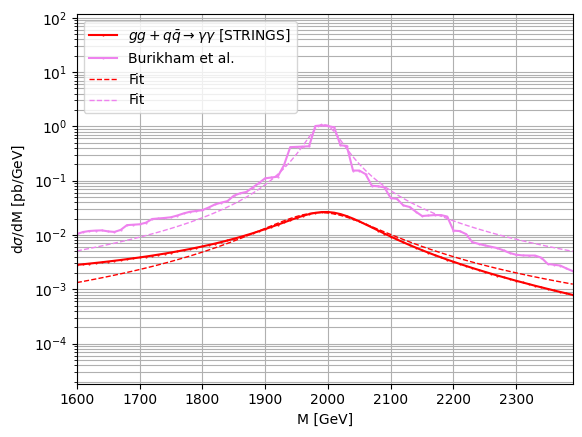

In [8]:
# 4 param Voigt fitting

fig, ax = plt.subplots()
plt.xlim(min(invariant_Mass_peak), max(invariant_Mass_peak))

def voigt(x, K, M, sigma, gamma):   # K, M, sigma, gamma
    z = (x - M + 1j * gamma) / (sigma * np.sqrt(2))
    return K * np.real(wofz(z))

initial_guess = [20, 2000, 3, 100]   # K, M, sigma, gamma guess

if gg_or_both == 'both':
    popt, pcov = curve_fit(voigt, invariant_Mass_peak, total_peak, p0=initial_guess)
if gg_or_both == 'gg':
    popt, pcov = curve_fit(voigt, invariant_Mass_peak, gg_cross_peak, p0=initial_guess)

our_fitted_K, our_fitted_M, our_fitted_sigma, our_fitted_gamma = popt
our_y_fit = [voigt(x, our_fitted_K, our_fitted_M, our_fitted_sigma, our_fitted_gamma) for x in invariant_Mass_peak]  # get fitted curve

print('STRINGS Fit params:')
print('K:', our_fitted_K, '+-', np.sqrt(pcov[0][0]))
print('M:', our_fitted_M, '+-', np.sqrt(pcov[1][1]))
print('Sigma:', our_fitted_sigma, '+-', np.sqrt(pcov[2][2]))
print('Gamma:', our_fitted_gamma, '+-', np.sqrt(pcov[3][3]))
print('----------------------')

initial_guess = [20, 2000, 3, 100]   # K, M, sigma, gamma guess

popt, pcov = curve_fit(voigt, invariant_Mass_peak, comparison_points_peak, p0=initial_guess)
their_fitted_K, their_fitted_M, their_fitted_sigma, their_fitted_gamma = popt
their_y_fit = [voigt(x, their_fitted_K, their_fitted_M, their_fitted_sigma, their_fitted_gamma) for x in invariant_Mass_peak]  # fitted curve

print('PAPER Fit params:')
print('K:', their_fitted_K, '+-', np.sqrt(pcov[0][0]))
print('M:', their_fitted_M, '+-', np.sqrt(pcov[1][1]))
print('Sigma:', their_fitted_sigma, '+-', np.sqrt(pcov[2][2]))
print('Gamma:', their_fitted_gamma, '+-', np.sqrt(pcov[3][3]))

if gg_or_both == 'both':
    plt.plot(invariant_Mass, total, label=r'$gg + q\bar{q} \rightarrow ll$ [STRINGS]', marker='o', color='red', alpha=1, markersize=0.5)
    plt.plot(invariant_Mass, comparison_points, label=r'Burikham et al.', marker='o', color='violet', alpha=1, markersize=0.5)
if gg_or_both == 'gg':
    plt.plot(invariant_Mass, gg_cross, label=r'$gg \rightarrow ll$ [STRINGS]', marker='o', color='red', alpha=1, markersize=0.5)
    plt.plot(invariant_Mass, comparison_points, label=r'Burikham et al.', marker='o', color='violet', alpha=1, markersize=0.5)

plt.plot(invariant_Mass_peak, our_y_fit, label='Fit', color='red', linestyle='--', linewidth=1, alpha=1)
plt.plot(invariant_Mass_peak, their_y_fit, label='Fit', color='violet', linestyle='--', linewidth=1, alpha=1)

plt.xlabel('M [GeV]')
plt.ylabel('d$\sigma$/dM [pb/GeV]')
plt.legend(loc='upper left')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')

if lin_or_log == 'lin':
    plt.ylim(0,(3/2 * max(comparison_points_peak)))
if lin_or_log == 'log':
    ax.set_yscale('log')

plt.savefig('./differential_curves/yy_both (lin).pdf',dpi=100,bbox_inches='tight')      # NAME FILE
plt.show()

STRINGS Fit params:
K: 182.25270159781232 +- 181282397.64209616
Sigma: 0.01596081218826387 +- 15901.42982829688
Gamma: 90.09756403097438 +- 6.530771285233597
----------------------
PAPER Fit params:
K: 1800.815444760625 +- 185367435.7796296
Sigma: 0.02072735917275309 +- 2130.3609730241515
Gamma: 27.550217162523772 +- 3.587068283888038


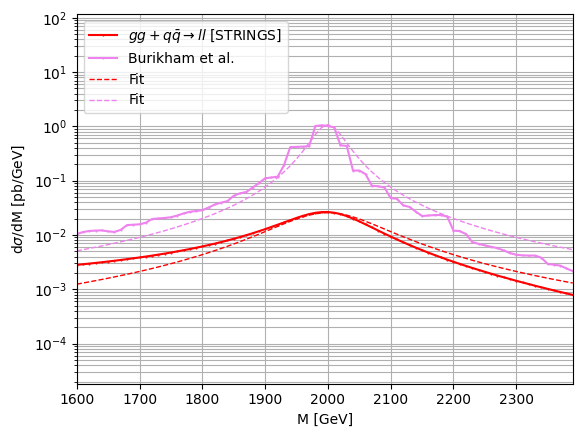

In [30]:
# 3 param Voigt fitting

fig, ax = plt.subplots()
plt.xlim(min(invariant_Mass_peak), max(invariant_Mass_peak))

def voigt(x, K, sigma, gamma):   # K, M, sigma, gamma
    z = (x - 2000 + 1j * gamma) / (sigma * np.sqrt(2))
    return K * np.real(wofz(z))

initial_guess = [1e5, 1, 100]   # K, sigma, gamma guess

if gg_or_both == 'both':
    popt, pcov = curve_fit(voigt, invariant_Mass_peak, total_peak, p0=initial_guess)
if gg_or_both == 'gg':
    popt, pcov = curve_fit(voigt, invariant_Mass_peak, gg_cross_peak, p0=initial_guess)

our_fitted_K, our_fitted_sigma, our_fitted_gamma = popt
our_y_fit = [voigt(x, our_fitted_K, our_fitted_sigma, our_fitted_gamma) for x in invariant_Mass_peak]  # get fitted curve

print('STRINGS Fit params:')
print('K:', our_fitted_K, '+-', np.sqrt(pcov[0][0]))
print('Sigma:', our_fitted_sigma, '+-', np.sqrt(pcov[1][1]))
print('Gamma:', our_fitted_gamma, '+-', np.sqrt(pcov[2][2]))
print('----------------------')

initial_guess = [1e5, 1, 100]   # K, sigma, gamma guess

popt, pcov = curve_fit(voigt, invariant_Mass_peak, comparison_points_peak, p0=initial_guess)
their_fitted_K, their_fitted_sigma, their_fitted_gamma = popt
their_y_fit = [voigt(x, their_fitted_K, their_fitted_sigma, their_fitted_gamma) for x in invariant_Mass_peak]  # fitted curve

print('PAPER Fit params:')
print('K:', their_fitted_K, '+-', np.sqrt(pcov[0][0]))
print('Sigma:', their_fitted_sigma, '+-', np.sqrt(pcov[1][1]))
print('Gamma:', their_fitted_gamma, '+-', np.sqrt(pcov[2][2]))

if gg_or_both == 'both':
    plt.plot(invariant_Mass, total, label=r'$gg + q\bar{q} \rightarrow ll$ [STRINGS]', marker='o', color='red', alpha=1, markersize=0.5)
    plt.plot(invariant_Mass, comparison_points, label=r'Burikham et al.', marker='o', color='violet', alpha=1, markersize=0.5)
if gg_or_both == 'gg':
    plt.plot(invariant_Mass, gg_cross, label=r'$gg \rightarrow ll$ [STRINGS]', marker='o', color='red', alpha=1, markersize=0.5)
    plt.plot(invariant_Mass, comparison_points, label=r'Burikham et al.', marker='o', color='violet', alpha=1, markersize=0.5)

plt.plot(invariant_Mass_peak, our_y_fit, label='Fit', color='red', linestyle='--', linewidth=1, alpha=1)
plt.plot(invariant_Mass_peak, their_y_fit, label='Fit', color='violet', linestyle='--', linewidth=1, alpha=1)

plt.xlabel('M [GeV]')
plt.ylabel('d$\sigma$/dM [pb/GeV]')
plt.legend(loc='upper left')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')

if lin_or_log == 'lin':
    plt.ylim(0,(3/2 * max(comparison_points_peak)))
if lin_or_log == 'log':
    ax.set_yscale('log')

plt.savefig('./differential_curves/yy_both (lin).pdf',dpi=100,bbox_inches='tight')      # NAME FILE
plt.show()

STRINGS Fit params:
Sigma: 0.003657353093984662 +- 7.983434275989555e-05
Gamma: 77.19616370519935 +- 2.407542024813927
----------------------
PAPER Fit params:
Sigma: 0.15251490066514148 +- 0.010450753325051337
Gamma: 22.94014542876393 +- 2.223129064916122


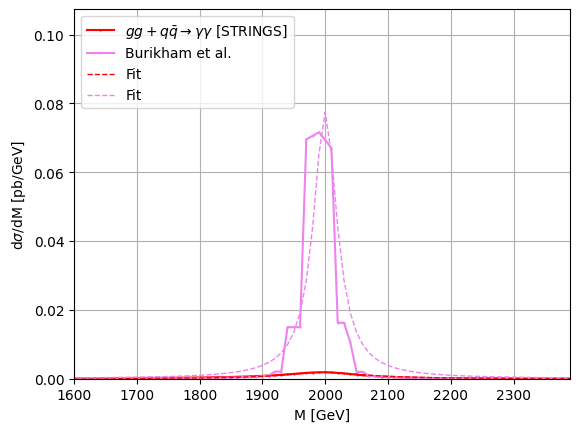

In [80]:
# 2 param Voigt fitting

fig, ax = plt.subplots()
plt.xlim(min(invariant_Mass_peak), max(invariant_Mass_peak))

def voigt(x, sigma, gamma):   # K, M, sigma, gamma
    M = 2000
    K = 2 * np.sqrt(2) * M * gamma / math.pi / np.sqrt(M**2 + M*np.sqrt(M**2 + gamma**2))
    z = (x - M + 1j * gamma) / (sigma * np.sqrt(2))
    return K * np.real(wofz(z))

initial_guess = [1, 100]   # sigma, gamma guess

if gg_or_both == 'both':
    popt, pcov = curve_fit(voigt, invariant_Mass_peak, total_peak, p0=initial_guess)
if gg_or_both == 'gg':
    popt, pcov = curve_fit(voigt, invariant_Mass_peak, gg_cross_peak, p0=initial_guess)

our_fitted_sigma, our_fitted_gamma = popt
our_y_fit = [voigt(x, our_fitted_sigma, our_fitted_gamma) for x in invariant_Mass_peak]  # get fitted curve

print('STRINGS Fit params:')
print('Sigma:', our_fitted_sigma, '+-', np.sqrt(pcov[0][0]))
print('Gamma:', our_fitted_gamma, '+-', np.sqrt(pcov[1][1]))
print('----------------------')

initial_guess = [1, 100]   # sigma, gamma guess

popt, pcov = curve_fit(voigt, invariant_Mass_peak, comparison_points_peak, p0=initial_guess)
their_fitted_sigma, their_fitted_gamma = popt
their_y_fit = [voigt(x, their_fitted_sigma, their_fitted_gamma) for x in invariant_Mass_peak]  # fitted curve

print('PAPER Fit params:')
print('Sigma:', their_fitted_sigma, '+-', np.sqrt(pcov[0][0]))
print('Gamma:', their_fitted_gamma, '+-', np.sqrt(pcov[1][1]))

if gg_or_both == 'both':
    plt.plot(invariant_Mass, total, label=r'$gg + q\bar{q} \rightarrow \gamma \gamma $ [STRINGS]', marker='o', color='red', alpha=1, markersize=0.5)
    plt.plot(invariant_Mass, comparison_points, label=r'Burikham et al.', marker='o', color='violet', alpha=1, markersize=0.5)
if gg_or_both == 'gg':
    plt.plot(invariant_Mass, gg_cross, label=r'$gg \rightarrow \gamma \gamma $ [STRINGS]', marker='o', color='red', alpha=1, markersize=0.5)
    plt.plot(invariant_Mass, comparison_points, label=r'Burikham et al.', marker='o', color='violet', alpha=1, markersize=0.5)

plt.plot(invariant_Mass_peak, our_y_fit, label='Fit', color='red', linestyle='--', linewidth=1, alpha=1)
plt.plot(invariant_Mass_peak, their_y_fit, label='Fit', color='violet', linestyle='--', linewidth=1, alpha=1)

plt.xlabel('M [GeV]')
plt.ylabel('d$\sigma$/dM [pb/GeV]')
plt.legend(loc='upper left')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')

if lin_or_log == 'lin':
    plt.ylim(0,(3/2 * max(comparison_points_peak)))
if lin_or_log == 'log':
    ax.set_yscale('log')

plt.savefig('./differential_curves/photon_both (lin).pdf',dpi=100,bbox_inches='tight')      # NAME FILE
plt.show()